# Setup

version 3: using UCI HAR Dataset without HHAR

In [1]:
# import libraries
import os
import sys
import time
import pandas as pd
import numpy as np
from scipy import stats
from scipy.interpolate import CubicSpline
import torch.optim as optim
import torch.nn as nn
import torch
from torch.optim import Adam
from scipy.fftpack import fft, ifft
from scipy.stats import mode
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## Hyperparameter

In [2]:
num_epochs = 200
batch_size = 64  # Set your batch size
learning_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# set the seed
torch.manual_seed(420)
np.random.seed(420)


# Data Loading

## SBHAR

In [4]:
#load dataset without header
data_sbhar = pd.read_csv('./ISWC21_data_plus_raw/sbhar_data.csv', header=None)
# add header
data_sbhar.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']
data_sbhar

,subject_id,acc_x,acc_y,acc_z,activity
0,0,0.443056,0.037500,0.888889,null_class
1,0,0.440278,0.041667,0.880556,null_class
2,0,0.451389,0.043056,0.876389,null_class
3,0,0.456944,0.034722,0.888889,null_class
4,0,0.447222,0.036111,0.888889,null_class
...,...,...,...,...,...
1122767,29,0.430556,0.501389,0.923611,null_class
1122768,29,0.430556,0.501389,0.923611,null_class
1122769,29,0.473611,0.493056,0.906944,null_class
1122770,29,0.472222,0.502778,0.884722,null_class


### Data Preprocessed

In [5]:
# drop activity with 'null_class'
data_sbhar = data_sbhar[data_sbhar['activity'] != 'null_class']
data_sbhar

,subject_id,acc_x,acc_y,acc_z,activity
251,0,0.990278,-0.337500,0.022222,standing
252,0,0.986111,-0.340278,0.012500,standing
253,0,0.987500,-0.333333,0.011111,standing
254,0,0.988889,-0.327778,0.012500,standing
255,0,0.986111,-0.333333,0.009722,standing
...,...,...,...,...,...
1121783,29,0.880556,-0.390278,-0.156944,walking_upstairs
1121784,29,0.834722,-0.358333,-0.098611,walking_upstairs
1121785,29,0.802778,-0.329167,-0.104167,walking_upstairs
1121786,29,0.770833,-0.287500,-0.098611,walking_upstairs


In [6]:
# check for missing values
data_sbhar.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [7]:
# print count of unique subjects
print(data_sbhar['subject_id'].nunique())

30


In [8]:
# print count of unique activities
print(data_sbhar['activity'].nunique())

12


In [9]:
data_sbhar['activity'].unique()

array(['standing', 'stand-to-sit', 'sitting', 'sit-to-stand',
       'stand-to-lie', 'lying', 'lie-to-sit', 'sit-to-lie',
       'lie-to-stand', 'walking', 'walking_downstairs',
       'walking_upstairs'], dtype=object)

In [10]:
# replace activity with a number
activity_dict = {
    'standing':1,
    'sitting':2,
    'lying':3,
    'walking':4,
    'walking_downstairs':5,
    'walking_upstairs':6,
    'stand-to-sit': 10,
    'sit-to-stand': 11,
    'sit-to-lie': 12,
    'lie-to-sit': 13,
    'stand-to-lie': 14,
    'lie-to-stand': 15,
}
data_sbhar = data_sbhar.replace({"activity": activity_dict})

In [11]:
print(data_sbhar['activity'].unique())

[ 1 10  2 11 14  3 13 12 15  4  5  6]


In [12]:
data_sbhar = data_sbhar[data_sbhar['activity'] != 10]
data_sbhar = data_sbhar[data_sbhar['activity'] != 11]
data_sbhar = data_sbhar[data_sbhar['activity'] != 12]
data_sbhar = data_sbhar[data_sbhar['activity'] != 13]
data_sbhar = data_sbhar[data_sbhar['activity'] != 14]
data_sbhar = data_sbhar[data_sbhar['activity'] != 15]

In [13]:
data_sbhar['activity'].value_counts()

activity
1    138105
3    136865
2    126677
4    122091
6    116707
5    107961
Name: count, dtype: int64

In [14]:
data_sbhar

,subject_id,acc_x,acc_y,acc_z,activity
251,0,0.990278,-0.337500,0.022222,1
252,0,0.986111,-0.340278,0.012500,1
253,0,0.987500,-0.333333,0.011111,1
254,0,0.988889,-0.327778,0.012500,1
255,0,0.986111,-0.333333,0.009722,1
...,...,...,...,...,...
1121783,29,0.880556,-0.390278,-0.156944,6
1121784,29,0.834722,-0.358333,-0.098611,6
1121785,29,0.802778,-0.329167,-0.104167,6
1121786,29,0.770833,-0.287500,-0.098611,6


In [15]:
print(data_sbhar['subject_id'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [16]:
# print count of unique subjects
print(data_sbhar['subject_id'].nunique())

30


In [17]:
# randomly pick 5 subject_id
np.random.seed(420)
subject_ids = np.random.choice(data_sbhar['subject_id'].unique(), 5, replace=False)

public_subject = []
public_subject = subject_ids
public_subject

array([ 9,  7, 26, 29,  1], dtype=int64)

## RealWorld

In [18]:
# load data without header
data_rwhar = pd.read_csv('./ISWC21_data_plus_raw/rwhar_data.csv', header=None)
# add header
data_rwhar.columns = ['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity']
data_rwhar

,subject_id,acc_x,acc_y,acc_z,activity
0,0,-9.57434,-2.02733,1.34506,climbing_up
1,0,-9.56479,-1.99597,1.39345,climbing_up
2,0,-9.55122,-1.98445,1.41139,climbing_up
3,0,-9.51335,-1.97557,1.42615,climbing_up
4,0,-9.52959,-1.98187,1.45395,climbing_up
...,...,...,...,...,...
3200798,14,-9.28186,-2.45740,-1.88879,lying
3200799,14,-9.28955,-2.59154,-1.90494,lying
3200800,14,-9.31358,-2.62135,-1.90950,lying
3200801,14,-9.26154,-2.64308,-1.93750,lying


In [19]:
# print count of unique subjects
print(data_rwhar['subject_id'].nunique())

15


In [20]:
# print count of unique activities
print(data_rwhar['activity'].nunique())

8


### Data Preprocessed

In [21]:
#check for missing values
data_rwhar.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [22]:
data_rwhar['subject_id'] = data_rwhar['subject_id'] + 30

In [23]:
print(data_rwhar['subject_id'].unique())

[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


In [24]:
print(data_rwhar['activity'].unique())

['climbing_up' 'standing' 'walking' 'sitting' 'running' 'climbing_down'
 'jumping' 'lying']


In [25]:
# replace activity with a number
activity_dict = {
    'standing':1,
    'sitting':2,
    'lying':3,
    'walking':4,
    'walking_downstairs':5,
    'walking_upstairs':6,
    'climbing_up':6,
    'climbing_down':5,
    'running':7,
    'jumping':8,
    'stand-to-sit': 10,
    'sit-to-stand': 11,
    'sit-to-lie': 12,
    'lie-to-sit': 13,
    'stand-to-lie': 14,
    'lie-to-stand': 15,
}
data_rwhar = data_rwhar.replace({"activity": activity_dict})

In [26]:
print(data_rwhar['activity'].value_counts())

activity
7    522013
4    482938
3    479455
2    478761
1    473147
6    371180
5    320302
8     73007
Name: count, dtype: int64


In [27]:
print(data_rwhar['subject_id'].value_counts())

subject_id
34    245822
37    243823
32    227821
38    224449
44    222116
40    220262
42    218636
35    215920
30    214659
41    212453
39    210260
33    207492
36    189243
43    179282
31    168565
Name: count, dtype: int64


In [28]:
data_rwhar['subject_id'].unique()

array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
      dtype=int64)

In [29]:
# randomly pick 5 subject_id
np.random.seed(420)
subject_ids = np.random.choice(data_rwhar['subject_id'].unique(), 5, replace=False)

# join the subject_ids to public_subject
public_subject = np.concatenate((public_subject, subject_ids))
public_subject

array([ 9,  7, 26, 29,  1, 32, 44, 35, 30, 41], dtype=int64)

In [30]:
data_rwhar

,subject_id,acc_x,acc_y,acc_z,activity
0,30,-9.57434,-2.02733,1.34506,6
1,30,-9.56479,-1.99597,1.39345,6
2,30,-9.55122,-1.98445,1.41139,6
3,30,-9.51335,-1.97557,1.42615,6
4,30,-9.52959,-1.98187,1.45395,6
...,...,...,...,...,...
3200798,44,-9.28186,-2.45740,-1.88879,3
3200799,44,-9.28955,-2.59154,-1.90494,3
3200800,44,-9.31358,-2.62135,-1.90950,3
3200801,44,-9.26154,-2.64308,-1.93750,3


## UCI

In [31]:
#load dataset without header
data_uci = pd.read_csv('./UCI HAR Dataset/uci_har.csv')
data_uci

,subject_id,acc_x,acc_y,acc_z,activity
0,1,1.012817,-0.123217,0.102934,STANDING
1,1,1.022833,-0.126876,0.105687,STANDING
2,1,1.022028,-0.124004,0.102102,STANDING
3,1,1.017877,-0.124928,0.106553,STANDING
4,1,1.023680,-0.125767,0.102814,STANDING
...,...,...,...,...,...
1318267,24,0.908386,-0.423054,-0.092933,WALKING_UPSTAIRS
1318268,24,0.898984,-0.392272,-0.063138,WALKING_UPSTAIRS
1318269,24,0.918862,-0.351680,-0.072539,WALKING_UPSTAIRS
1318270,24,0.949475,-0.267526,-0.050975,WALKING_UPSTAIRS


### Data Preprocessed

In [32]:
# drop activity with 'null_class'
data_uci = data_uci[data_uci['activity'] != 'null_class']

In [33]:
data_uci

,subject_id,acc_x,acc_y,acc_z,activity
0,1,1.012817,-0.123217,0.102934,STANDING
1,1,1.022833,-0.126876,0.105687,STANDING
2,1,1.022028,-0.124004,0.102102,STANDING
3,1,1.017877,-0.124928,0.106553,STANDING
4,1,1.023680,-0.125767,0.102814,STANDING
...,...,...,...,...,...
1318267,24,0.908386,-0.423054,-0.092933,WALKING_UPSTAIRS
1318268,24,0.898984,-0.392272,-0.063138,WALKING_UPSTAIRS
1318269,24,0.918862,-0.351680,-0.072539,WALKING_UPSTAIRS
1318270,24,0.949475,-0.267526,-0.050975,WALKING_UPSTAIRS


In [34]:
# check for missing values
data_uci.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [35]:
# print count of unique subjects
print(data_uci['subject_id'].nunique())

30


In [36]:
# print count of unique activities
print(data_uci['activity'].nunique())

6


In [37]:
data_uci['subject_id'].unique()

array([ 1,  3,  5,  6,  7,  8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26,
       27, 28, 29, 30,  2,  4,  9, 10, 12, 13, 18, 20, 24], dtype=int64)

In [38]:
# change subject_id number
data_uci['subject_id'] = data_uci['subject_id'] + 44

In [39]:
print(data_uci['subject_id'].unique())

[45 47 49 50 51 52 55 58 59 60 61 63 65 66 67 69 70 71 72 73 74 46 48 53
 54 56 57 62 64 68]


In [40]:
data_uci['activity'].value_counts()

activity
LAYING                248832
STANDING              243968
SITTING               227456
WALKING               220416
WALKING_UPSTAIRS      197632
WALKING_DOWNSTAIRS    179968
Name: count, dtype: int64

In [41]:
# replace activity with a number
activity_dict = {
        'standing':1,
        'sitting':2,
        'lying':3,
        'walking':4,
        'walking_downstairs':5,
        'walking_upstairs':6,
        'climbing_up':6,
        'climbing_down':5,
        'running':7,
        'jumping':8,
        'stand-to-sit': 10,
        'sit-to-stand': 11,
        'sit-to-lie': 12,
        'lie-to-sit': 13,
        'stand-to-lie': 14,
        'lie-to-stand': 15,
        'LAYING': 3,
        'STANDING': 1,
        'SITTING': 2,
        'WALKING': 4,
        'WALKING_UPSTAIRS': 6,
        'WALKING_DOWNSTAIRS': 5,
}
data_uci = data_uci.replace({"activity": activity_dict})

In [42]:
print(data_uci['activity'].unique())

[1 2 3 4 5 6]


In [43]:
data_uci['activity'].value_counts()

activity
3    248832
1    243968
2    227456
4    220416
6    197632
5    179968
Name: count, dtype: int64

In [44]:
data_uci['subject_id'].unique()

array([45, 47, 49, 50, 51, 52, 55, 58, 59, 60, 61, 63, 65, 66, 67, 69, 70,
       71, 72, 73, 74, 46, 48, 53, 54, 56, 57, 62, 64, 68], dtype=int64)

In [45]:
# randomly pick 5 subject_id
np.random.seed(420)
subject_ids = np.random.choice(data_uci['subject_id'].unique(), 5, replace=False)

# join the subject_ids to public_subject
public_subject = np.concatenate((public_subject, subject_ids))
public_subject

array([ 9,  7, 26, 29,  1, 32, 44, 35, 30, 41, 60, 58, 57, 68, 47],
      dtype=int64)

In [46]:
len(public_subject)

15

## Data Merging

In [47]:
# merge all datasets
data = pd.concat([data_sbhar, data_rwhar, data_uci], ignore_index=True)
data

,subject_id,acc_x,acc_y,acc_z,activity
0,0,0.990278,-0.337500,0.022222,1
1,0,0.986111,-0.340278,0.012500,1
2,0,0.987500,-0.333333,0.011111,1
3,0,0.988889,-0.327778,0.012500,1
4,0,0.986111,-0.333333,0.009722,1
...,...,...,...,...,...
5267476,68,0.908386,-0.423054,-0.092933,6
5267477,68,0.898984,-0.392272,-0.063138,6
5267478,68,0.918862,-0.351680,-0.072539,6
5267479,68,0.949475,-0.267526,-0.050975,6


In [48]:
#check for missing values
data.isnull().sum()

subject_id    0
acc_x         0
acc_y         0
acc_z         0
activity      0
dtype: int64

In [49]:
# check for unique subjects
print(data['subject_id'].nunique())

75


In [50]:
# print all of the unique subjects and sort them from smallest to largest
print(np.sort(data['subject_id'].unique()))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74]


In [51]:
# check for unique activities
print(data['activity'].nunique())

8


In [52]:
# print all of the unique activities and sort them from smallest to largest
print(np.sort(data['activity'].unique()))

[1 2 3 4 5 6 7 8]


In [53]:
# print the count of each activity
print(data['activity'].value_counts())

activity
3    865152
1    855220
2    832894
4    825445
6    685519
5    608231
7    522013
8     73007
Name: count, dtype: int64


In [54]:
print(data['subject_id'].value_counts())    

subject_id
34    245822
37    243823
32    227821
38    224449
44    222116
       ...  
6      22220
4      22079
8      21947
9      21747
7      20977
Name: count, Length: 75, dtype: int64


# Data Preprocess

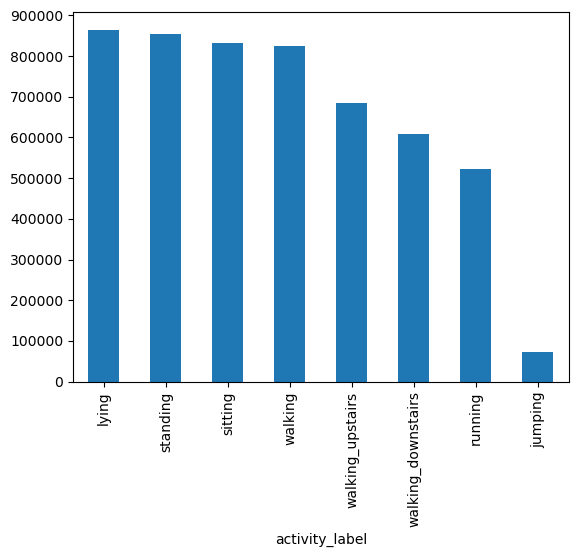

In [55]:
# label dictionary
label_dict = {
        1: 'standing',
        2: 'sitting',
        3: 'lying',
        4: 'walking',
        5: 'walking_downstairs',
        6: 'walking_upstairs',
        7: 'running',
        8: 'jumping',
        10: 'stand-to-sit',
        11: 'sit-to-stand',
        12: 'sit-to-lie',
        13: 'lie-to-sit',
        14: 'stand-to-lie',
        15: 'lie-to-stand',
}

# visualize the label distribution using label dictionary with y axis use integer
data['activity_label'] = data['activity'].map(label_dict)
ax = data['activity_label'].value_counts().plot(kind='bar')

# Setting the y-axis to display only integer values
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

<Axes: xlabel='subject_id'>

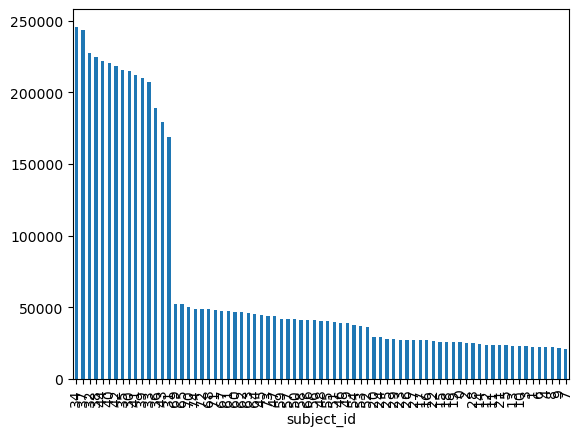

In [56]:
# visualize the subject distribution
data['subject_id'].value_counts().plot(kind='bar')

In [57]:
#drop activity_label
data = data.drop(columns=['activity_label'])

In [58]:
data

,subject_id,acc_x,acc_y,acc_z,activity
0,0,0.990278,-0.337500,0.022222,1
1,0,0.986111,-0.340278,0.012500,1
2,0,0.987500,-0.333333,0.011111,1
3,0,0.988889,-0.327778,0.012500,1
4,0,0.986111,-0.333333,0.009722,1
...,...,...,...,...,...
5267476,68,0.908386,-0.423054,-0.092933,6
5267477,68,0.898984,-0.392272,-0.063138,6
5267478,68,0.918862,-0.351680,-0.072539,6
5267479,68,0.949475,-0.267526,-0.050975,6


In [59]:
data['activity'] = data['activity'] - 1

In [60]:
# check for unique subjects
print(data['subject_id'].nunique())

75


In [61]:
data

,subject_id,acc_x,acc_y,acc_z,activity
0,0,0.990278,-0.337500,0.022222,0
1,0,0.986111,-0.340278,0.012500,0
2,0,0.987500,-0.333333,0.011111,0
3,0,0.988889,-0.327778,0.012500,0
4,0,0.986111,-0.333333,0.009722,0
...,...,...,...,...,...
5267476,68,0.908386,-0.423054,-0.092933,5
5267477,68,0.898984,-0.392272,-0.063138,5
5267478,68,0.918862,-0.351680,-0.072539,5
5267479,68,0.949475,-0.267526,-0.050975,5


In [62]:
data['activity'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [63]:
# z-normalization of acc_x, acc_y, and acc_z
data['acc_x'] = (data['acc_x'] - data['acc_x'].mean()) / data['acc_x'].std()
data['acc_y'] = (data['acc_y'] - data['acc_y'].mean()) / data['acc_y'].std()
data['acc_z'] = (data['acc_z'] - data['acc_z'].mean()) / data['acc_z'].std()

## Partitioned the Data for Train and Test

In [64]:
public_subject

array([ 9,  7, 26, 29,  1, 32, 44, 35, 30, 41, 60, 58, 57, 68, 47],
      dtype=int64)

In [65]:
private_subject = data['subject_id'].unique()
private_subject = np.setdiff1d(private_subject, public_subject)
private_subject

array([ 0,  2,  3,  4,  5,  6,  8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 39, 40, 42,
       43, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 59, 61, 62, 63, 64,
       65, 66, 67, 69, 70, 71, 72, 73, 74], dtype=int64)

In [66]:
# remove public_subject from the data
server_data = data[data['subject_id'].isin(public_subject)]
data = data[~data['subject_id'].isin(public_subject)]

# print the shape of server_data and data
print("Shape of server_data:", server_data.shape)
print("Shape of data:", data.shape)

Shape of server_data: (1435625, 5)
Shape of data: (3831856, 5)


In [67]:
# print the count of labels for server_data
server_data['activity'].value_counts()

activity
2    221113
0    219593
3    217763
1    217579
5    194136
4    175957
6    165578
7     23906
Name: count, dtype: int64

In [68]:
data.shape[0] / (data.shape[0] + server_data.shape[0])

0.7274551156425624

In [69]:
# disabiling the warnings
import warnings
warnings.filterwarnings("ignore")

In [70]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

data_test = {}
data_unlabelled_train = {}

# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for subject in np.sort(data['subject_id'].unique()):
    subject_data = data[data['subject_id'] == subject]
    labels = subject_data['activity'].values  # Assuming 'label' is your class label column

    # Drop the subject_id column
    subject_data = subject_data.drop(columns=['subject_id'])
    
    # Perform stratified split for train and test
    for train_index, test_index in sss.split(subject_data, labels):
        train_data, test_data = subject_data.iloc[train_index], subject_data.iloc[test_index]
        train_labels = labels[train_index]
    
    # Store splits
    data_test[subject] = test_data
    data_unlabelled_train[subject] = train_data

# Verify the split
for subject in np.sort(data['subject_id'].unique()):
    print('Subject:', subject)
    print('Test:', data_test[subject].shape)
    print('Unlabelled Train:', data_unlabelled_train[subject].shape)

Subject: 0
Test: (5084, 4)
Unlabelled Train: (20335, 4)
Subject: 2
Test: (4976, 4)
Unlabelled Train: (19902, 4)
Subject: 3
Test: (4567, 4)
Unlabelled Train: (18266, 4)
Subject: 4
Test: (4416, 4)
Unlabelled Train: (17663, 4)
Subject: 5
Test: (4683, 4)
Unlabelled Train: (18729, 4)
Subject: 6
Test: (4444, 4)
Unlabelled Train: (17776, 4)
Subject: 8
Test: (4390, 4)
Unlabelled Train: (17557, 4)
Subject: 10
Test: (4643, 4)
Unlabelled Train: (18571, 4)
Subject: 11
Test: (4736, 4)
Unlabelled Train: (18940, 4)
Subject: 12
Test: (4762, 4)
Unlabelled Train: (19047, 4)
Subject: 13
Test: (4653, 4)
Unlabelled Train: (18612, 4)
Subject: 14
Test: (4823, 4)
Unlabelled Train: (19292, 4)
Subject: 15
Test: (5194, 4)
Unlabelled Train: (20775, 4)
Subject: 16
Test: (5384, 4)
Unlabelled Train: (21532, 4)
Subject: 17
Test: (5387, 4)
Unlabelled Train: (21547, 4)
Subject: 18
Test: (5183, 4)
Unlabelled Train: (20731, 4)
Subject: 19
Test: (5142, 4)
Unlabelled Train: (20565, 4)
Subject: 20
Test: (5844, 4)
Unlabelled

## Windowing the Data

In [71]:
def sliding_window_samples(data, samples_per_window, overlap_ratio):
    """
    Return a sliding window measured in number of samples over a data array along with the mode label for each window.

    :param data: input array, can be numpy or pandas dataframe
    :param samples_per_window: window length as number of samples
    :param overlap_ratio: overlap is meant as percentage and should be an integer value
    :return: tuple of windows, indices, and labels
    """
    windows = []
    indices = []
    labels = []
    curr = 0
    win_len = int(samples_per_window)
    if overlap_ratio is not None:
        overlapping_elements = int((overlap_ratio / 100) * win_len)
        if overlapping_elements >= win_len:
            print('Number of overlapping elements exceeds window size.')
            return
    while curr < len(data) - win_len:
        window = data[curr:curr + win_len]
        windows.append(window.iloc[:, :-1])  # Exclude the last column which is the label
        indices.append([curr, curr + win_len])
        
        # Extract and compute the mode of the encoded labels for the current window
        window_labels = window['activity']
        mode_result = mode(window_labels)
        window_label = mode_result[0] if mode_result[0].size > 0 else mode_result
        labels.append(window_label)

        curr += win_len - overlapping_elements

    result_windows = np.array(windows)
    result_indices = np.array(indices)
    result_labels = np.array(labels)
    return result_windows, result_indices, result_labels

In [72]:
# windowing the data for each subject
sampling_rate = 50
time_window = 2.56
window_size = sampling_rate * time_window
overlap_ratio = 50 # 50% overlap

print('Window size:', window_size)
print('Overlap ratio %:', overlap_ratio)

windowed_unlabelled_train_x = []
windowed_test_x = []
windowed_unlabelled_train_y = []
windowed_test_y = []

# Iterate over each client and apply the sliding window
for subject in np.sort(data['subject_id'].unique()):
    unlabelled_train_data = data_unlabelled_train[subject]
    test_data = data_test[subject]
    unlabelled_train_windows, _, unlabelled_train_labels = sliding_window_samples(unlabelled_train_data, window_size, overlap_ratio)
    test_windows, _, test_labels = sliding_window_samples(test_data, window_size, overlap_ratio)

    windowed_unlabelled_train_x.append(unlabelled_train_windows)
    windowed_test_x.append(test_windows)

    windowed_unlabelled_train_y.append(unlabelled_train_labels)
    windowed_test_y.append(test_labels)

    print('Subject:', subject, 'Unlabelled Train Data shape:', unlabelled_train_windows.shape, 'Unlabelled Train Labels shape:', unlabelled_train_labels.shape)
    print('Subject:', subject, 'Test Data shape:', test_windows.shape, 'Test Labels shape:', test_labels.shape)

Window size: 128.0
Overlap ratio %: 50
Subject: 0 Unlabelled Train Data shape: (316, 128, 3) Unlabelled Train Labels shape: (316,)
Subject: 0 Test Data shape: (78, 128, 3) Test Labels shape: (78,)
Subject: 2 Unlabelled Train Data shape: (309, 128, 3) Unlabelled Train Labels shape: (309,)
Subject: 2 Test Data shape: (76, 128, 3) Test Labels shape: (76,)
Subject: 3 Unlabelled Train Data shape: (284, 128, 3) Unlabelled Train Labels shape: (284,)
Subject: 3 Test Data shape: (70, 128, 3) Test Labels shape: (70,)
Subject: 4 Unlabelled Train Data shape: (274, 128, 3) Unlabelled Train Labels shape: (274,)
Subject: 4 Test Data shape: (67, 128, 3) Test Labels shape: (67,)
Subject: 5 Unlabelled Train Data shape: (291, 128, 3) Unlabelled Train Labels shape: (291,)
Subject: 5 Test Data shape: (72, 128, 3) Test Labels shape: (72,)
Subject: 6 Unlabelled Train Data shape: (276, 128, 3) Unlabelled Train Labels shape: (276,)
Subject: 6 Test Data shape: (68, 128, 3) Test Labels shape: (68,)
Subject: 8 Un

In [73]:
windowed_unlabelled_train_x[0]

array([[[ 0.64076615,  0.55409497, -0.39327985],
        [ 0.64537992,  0.67630908, -0.23801366],
        [ 0.65679289,  0.5589966 , -0.34868211],
        ...,
        [ 0.66019251,  0.5805638 , -0.35487624],
        [ 0.66990569,  0.61258782, -0.39493162],
        [ 0.65727855,  0.56389824, -0.36189626]],

       [[ 0.71361497,  0.52370483, -0.45233055],
        [ 0.59292876,  0.63056048, -0.38749866],
        [ 0.65193631,  0.59657581, -0.38625983],
        ...,
        [ 0.66869154,  0.60082389, -0.38584689],
        [ 0.63105299,  0.63546212, -0.42053402],
        [ 0.66213515,  0.60735941, -0.3259703 ]],

       [[ 0.70414462,  0.59494193, -0.34703034],
        [ 0.66844871,  0.56324469, -0.40566811],
        [ 0.64975084,  0.67402165, -0.25700899],
        ...,
        [ 0.53610668,  0.82825978, -0.20828183],
        [ 0.65582157,  0.56357146, -0.35859272],
        [ 0.65047933,  0.67500197, -0.25783487]],

       ...,

       [[ 0.65582157,  0.55932338, -0.35239859],
        [ 0

In [74]:
windowed_unlabelled_train_y[0]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 3, 0, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 0, 4, 4, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [75]:
# windowing the data for each subject
sampling_rate = 50
time_window = 2.56
window_size = sampling_rate * time_window
overlap_ratio = 50 # 50% overlap

print('Window size:', window_size)
print('Overlap ratio %:', overlap_ratio)

windowed_labelled_train_x = []
windowed_labelled_train_y = []

# Iterate over each client and apply the sliding window
for subject in np.sort(server_data['subject_id'].unique()):
    unlabelled_train_data = server_data[server_data['subject_id'] == subject]
    unlabelled_train_data = unlabelled_train_data.drop(columns=['subject_id'])

    labelled_train_windows, _, labelled_train_labels = sliding_window_samples(unlabelled_train_data, window_size, overlap_ratio)

    windowed_labelled_train_x.append(labelled_train_windows)
    windowed_labelled_train_y.append(labelled_train_labels)

    print('Subject:', subject, 'Labelled Train Data shape:', labelled_train_windows.shape, 'Labelled Train Labels shape:', labelled_train_labels.shape)

Window size: 128.0
Overlap ratio %: 50


Subject: 1 Labelled Train Data shape: (347, 128, 3) Labelled Train Labels shape: (347,)
Subject: 7 Labelled Train Data shape: (326, 128, 3) Labelled Train Labels shape: (326,)
Subject: 9 Labelled Train Data shape: (338, 128, 3) Labelled Train Labels shape: (338,)
Subject: 26 Labelled Train Data shape: (425, 128, 3) Labelled Train Labels shape: (425,)
Subject: 29 Labelled Train Data shape: (434, 128, 3) Labelled Train Labels shape: (434,)
Subject: 30 Labelled Train Data shape: (3353, 128, 3) Labelled Train Labels shape: (3353,)
Subject: 32 Labelled Train Data shape: (3558, 128, 3) Labelled Train Labels shape: (3558,)
Subject: 35 Labelled Train Data shape: (3372, 128, 3) Labelled Train Labels shape: (3372,)
Subject: 41 Labelled Train Data shape: (3318, 128, 3) Labelled Train Labels shape: (3318,)
Subject: 44 Labelled Train Data shape: (3469, 128, 3) Labelled Train Labels shape: (3469,)
Subject: 47 Labelled Train Data shape: (680, 128, 3) Labelled Train Labels shape: (680,)
Subject: 57 La

# Saved the FL Data

In [79]:
print(np.sort(public_subject))
print(np.sort(private_subject))

[ 1  7  9 26 29 30 32 35 41 44 47 57 58 60 68]
[ 0  2  3  4  5  6  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27
 28 31 33 34 36 37 38 39 40 42 43 45 46 48 49 50 51 52 53 54 55 56 59 61
 62 63 64 65 66 67 69 70 71 72 73 74]


In [76]:
### Save labeled train data
path = f"FL_Data/windowed_data_filtered_w_UCI3/subject_"

idx = 0
for i in np.sort(public_subject):
    subject = i
    subject_dir = path + str(subject)
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    print(f"Subject: {subject} | idx: {idx}")
    np.save(f"{subject_dir}/windowed_labelled_train_x.npy", windowed_labelled_train_x[idx])
    np.save(f"{subject_dir}/windowed_labelled_train_y.npy", windowed_labelled_train_y[idx])
    print('*' * 50)
    idx += 1

print()
print("="*50)
print("Test the Save Data")
print("="*50)
print()

idx = 0
for i in np.sort(public_subject):
    subject = i
    subject_dir = path + str(subject)
    print('Subject:', subject)
    print('Labelled Train Data:', np.array_equal(windowed_labelled_train_x[idx], np.load(subject_dir + '/windowed_labelled_train_x.npy')))
    print('Labelled Train Labels:', np.array_equal(windowed_labelled_train_y[idx], np.load(subject_dir + '/windowed_labelled_train_y.npy')))
    print('*' * 50)
    idx += 1

Subject: 1 | idx: 0
**************************************************
Subject: 7 | idx: 1
**************************************************
Subject: 9 | idx: 2
**************************************************
Subject: 26 | idx: 3
**************************************************
Subject: 29 | idx: 4
**************************************************
Subject: 30 | idx: 5
**************************************************
Subject: 32 | idx: 6
**************************************************
Subject: 35 | idx: 7
**************************************************
Subject: 41 | idx: 8
**************************************************
Subject: 44 | idx: 9
**************************************************
Subject: 47 | idx: 10
**************************************************
Subject: 57 | idx: 11
**************************************************
Subject: 58 | idx: 12
**************************************************
Subject: 60 | idx: 13
******************************************

In [77]:
# save unlabeled and test data

idx = 0
for i in np.sort(private_subject):
    subject = i
    subject_dir = path + str(subject)
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    print(f"Subject: {subject} | idx: {idx}")
    np.save(f"{subject_dir}/windowed_unlabelled_train_x.npy", windowed_unlabelled_train_x[idx])
    np.save(f"{subject_dir}/windowed_unlabelled_train_y.npy", windowed_unlabelled_train_y[idx])
    np.save(f"{subject_dir}/windowed_test_x.npy", windowed_test_x[idx])
    np.save(f"{subject_dir}/windowed_test_y.npy", windowed_test_y[idx])
    print('*' * 50)
    idx += 1

print()
print("="*50)
print("Test the Save Data")
print("="*50)
print()

idx = 0
for i in np.sort(private_subject):
    subject = i
    subject_dir = path + str(subject)
    print('Subject:', subject)
    print('Unlabelled Train Data:', np.array_equal(windowed_unlabelled_train_x[idx], np.load(subject_dir + '/windowed_unlabelled_train_x.npy')))
    print('Unlabelled Train Labels:', np.array_equal(windowed_unlabelled_train_y[idx], np.load(subject_dir + '/windowed_unlabelled_train_y.npy')))
    print('Test Data:', np.array_equal(windowed_test_x[idx], np.load(subject_dir + '/windowed_test_x.npy')))
    print('Test Labels:', np.array_equal(windowed_test_y[idx], np.load(subject_dir + '/windowed_test_y.npy')))
    print('*' * 50)
    idx += 1

Subject: 0 | idx: 0
**************************************************
Subject: 2 | idx: 1
**************************************************
Subject: 3 | idx: 2
**************************************************
Subject: 4 | idx: 3
**************************************************
Subject: 5 | idx: 4
**************************************************
Subject: 6 | idx: 5
**************************************************
Subject: 8 | idx: 6
**************************************************
Subject: 10 | idx: 7
**************************************************
Subject: 11 | idx: 8
**************************************************
Subject: 12 | idx: 9
**************************************************
Subject: 13 | idx: 10
**************************************************
Subject: 14 | idx: 11
**************************************************
Subject: 15 | idx: 12
**************************************************
Subject: 16 | idx: 13
**********************************************

In [80]:
# print public_subject as a list with comma
public_subject.tolist()

[9, 7, 26, 29, 1, 32, 44, 35, 30, 41, 60, 58, 57, 68, 47]

In [82]:
print(private_subject.tolist())

[0, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 36, 37, 38, 39, 40, 42, 43, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 59, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74]
